In [1]:
%matplotlib inline
# %load ../../utility/initialization.py
'''
How to Train Your Dragon: V4
Sequentially initialize FT reactive distillation model automatically
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-04 16:09:47 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=1e-5,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)
        
for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
    return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
            sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
check_DOF(pe,model)

Active Equality Constraints:	 29862
Active Inequality Constraints:	 21
Active Variables:		 33597
Fixed Variables:		 3662
DOF:				 73


In [16]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [17]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
    

In [18]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

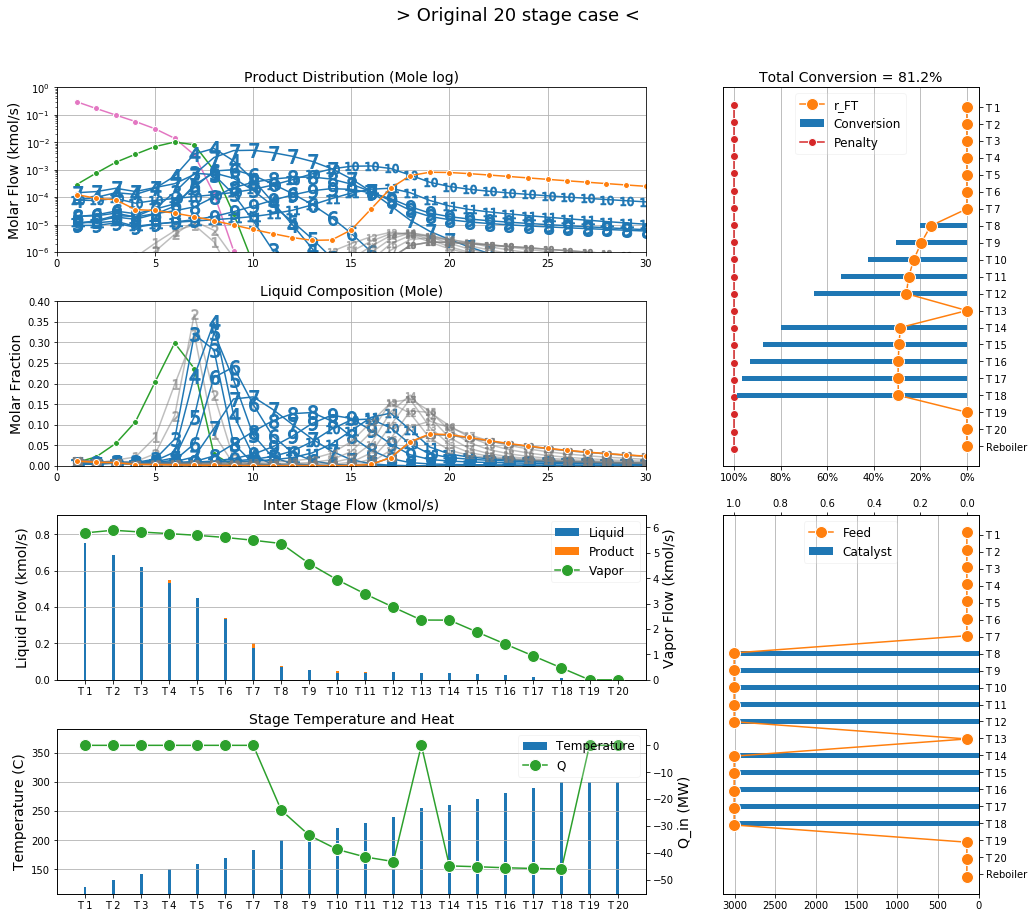

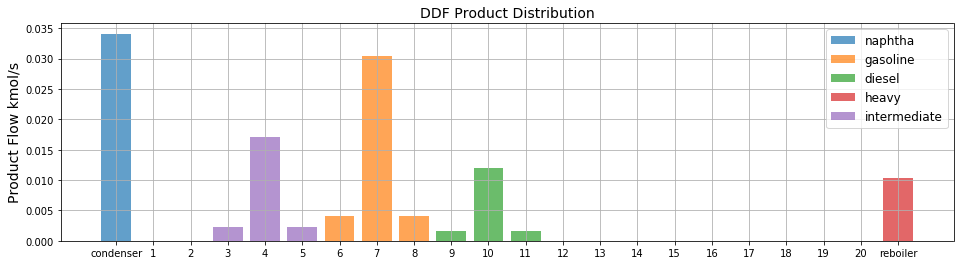

In [19]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [20]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

In [21]:
model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [22]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

In [23]:
def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [24]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [25]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
    

  66 -1.0235869e-01 2.50e-02 4.00e-01  -9.0 2.35e+01    -  1.00e+00 9.85e-01h  1
  67 -1.0235758e-01 1.05e-04 1.74e-04  -9.0 9.56e-01    -  1.00e+00 1.00e+00h  1
  68 -1.0235758e-01 3.05e-10 9.07e-11  -9.0 2.47e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:  -1.0235758259786909e-01   -1.0235758259786909e-01
Dual infeasibility......:   9.0656857397447685e-11    9.0656857397447685e-11
Constraint violation....:   3.0548505413653670e-10    3.0548505413653670e-10
Complementarity.........:   1.4416909291517724e-09    1.4416909291517724e-09
Overall NLP error.......:   1.4416909291517724e-09    1.4416909291517724e-09


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 83
Number of inequality constraint evaluations          = 83
Number of equality constraint Jacobi


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.03%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1386          0.9921  0.0871       2.3285

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.7  0.000       0.000  0.000  0.000  0.000       5.5466  0.0000  1.2312  0.0000       20.000
NON--[2]     149.7  0.000       0.000  0.000  0.000  0.000       5.7857  0.0000  1.1758  0.0000       20.000
NON--[3]     160.9  0.000       0.000  0.000  0.000  0.000       5.7303  0.0000  1.1268  0.0000       20.000
NON--[4]     170.0  0.00

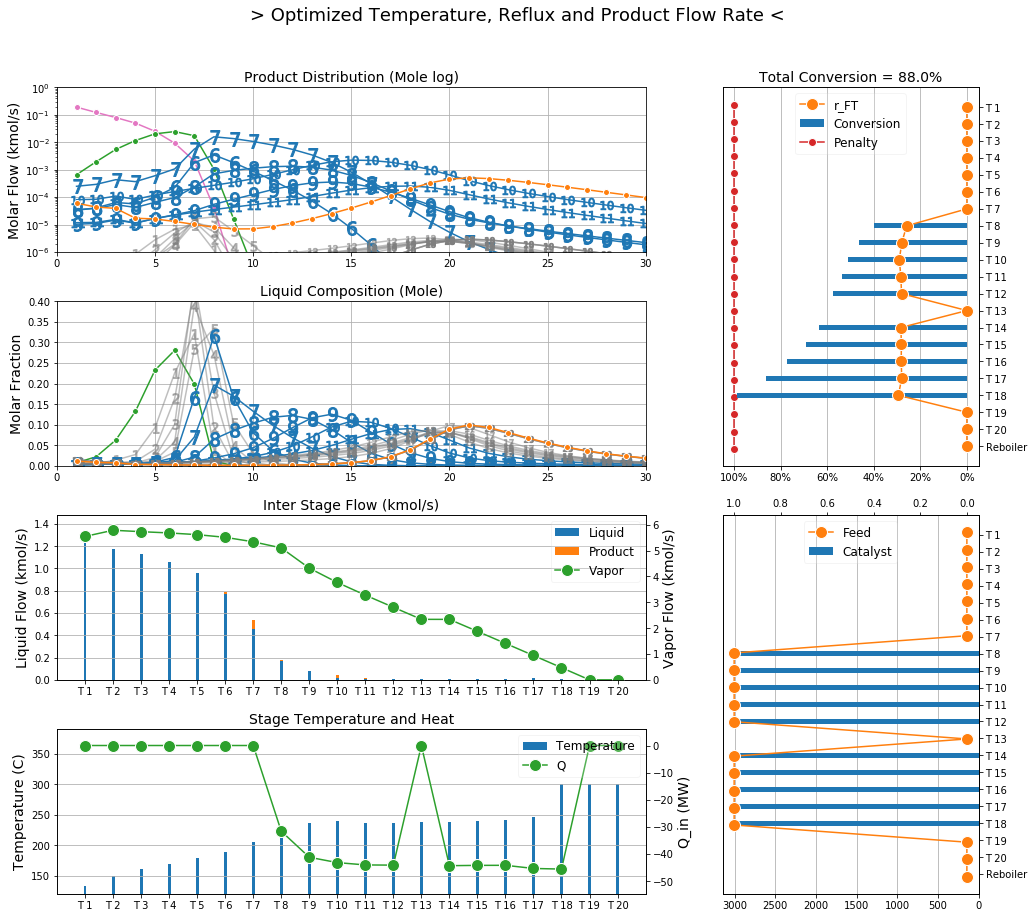

In [26]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')

# Open up feed allocation

In [27]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)

In [28]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [29]:
opt.options['required_infeasibility_reduction'] = 0.999999999999999

In [30]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2059798e-01 2.54e+01 1.39e+01  -6.0 1.48e+03    -  8.16e-02 8.50e-01H  1
  66 -1.2063680e-01 1.59e-01 4.94e+00  -6.0 8.60e+01    -  2.72e-01 1.00e+00h  1
  67 -1.2065672e-01 3.44e-01 3.81e-01  -6.0 9.05e+01  -9.5 1.00e+00 1.00e+00h  1
  68 -1.2071206e-01 3.86e+00 3.88e+00  -6.0 5.88e+02    -  9.31e-02 1.00e+00H  1
  69 -1.2071738e-01 1.58e-03 1.77e-01  -6.0 9.72e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2077458e-01 2.29e+00 1.56e+00  -6.0 2.30e+03    -  9.87e-02 1.20e-01h  4
  71 -1.2088905e-01 1.46e+00 4.88e+00  -6.0 5.01e+02    -  1.00e+00 1.00e+00H  1
  72 -1.2084296e-01 8.65e-01 5.91e-01  -6.0 2.39e+02    -  1.00e+00 1.00e+00h  1
  73 -1.2083970e-01 2.50e-03 6.48e-03  -6.0 1.37e+01    -  1.00e+00 1.00e+00h  1
  74 -1.2083964e-01 1.65e-06 1.62e-06  -6.0 3.32e-01    -  1.00e+00 1.00e+00h  1
  75 -1.2129976e-01 6.78e+01 1.16e+02  -9.0 8.56e+03    -  1.41e-01 2.49e-01h  1
  76 -1.2134227e-01 5.98e+01


> Optimized Feed Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.50%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -149.                                        1.8411          0.6318  0.0962       2.4205

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.4  0.000       0.000  0.000  0.000  0.000       4.9897  0.0000  0.7452  0.0000       20.000
NON--[2]     135.1  0.000       0.000  0.000  0.000  0.000       5.1031  0.0000  0.6909  0.0000       20.000
NON--[3]     142.8  0.000       0.000  0.000  0.000  0.000       5.0488  0.0000  0.6504  0.0000       20.000
NON--[4]     149.8  0.000       0.000  0.

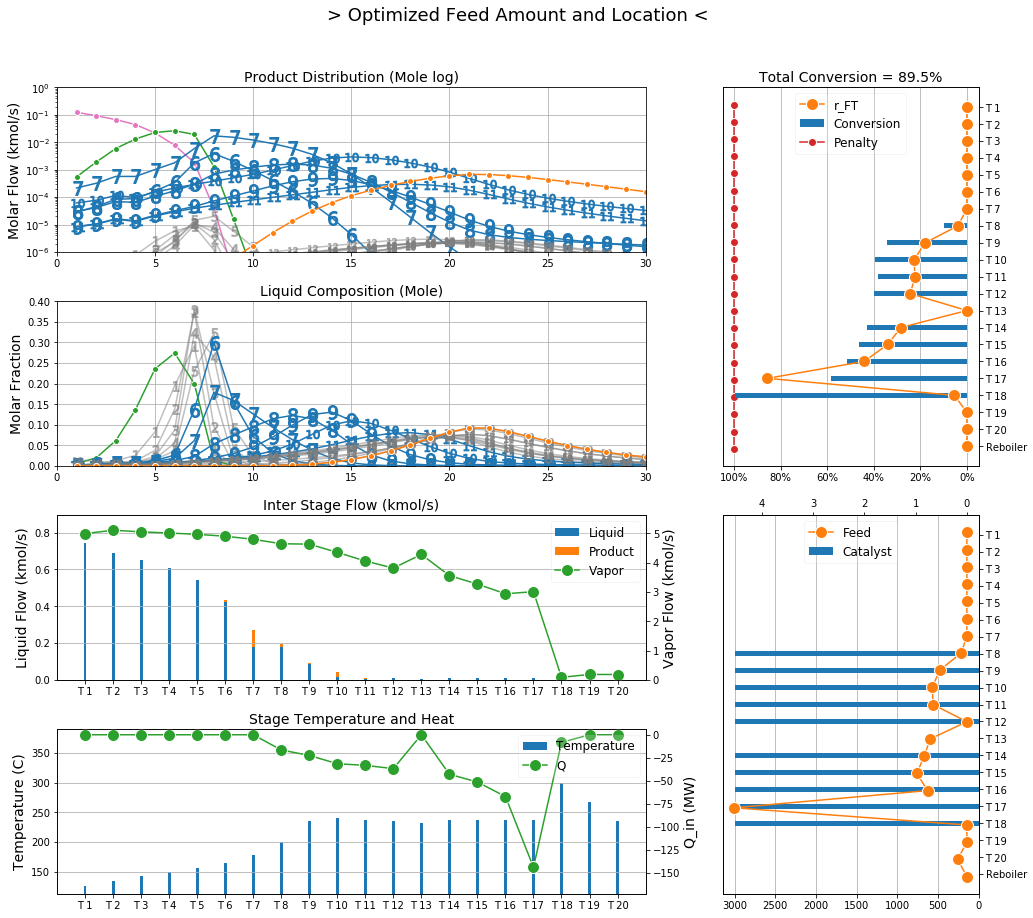

In [31]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Feed Amount and Location')

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [32]:
for j in model.reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(10)
    model.reactive[j].cat.setub(30000)

In [33]:
model.total_cat_con = pe.ConstraintList()
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [34]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.1662407e-01 3.78e+01 1.48e+04  -6.0 1.76e+02    -  2.70e-02 3.37e-02h  1
  66 -1.1660789e-01 3.74e+01 1.46e+04  -6.0 3.94e+02    -  2.83e-02 1.16e-02h  1
  67 -1.1648027e-01 3.68e+01 1.43e+04  -6.0 8.93e+02    -  2.36e-02 1.67e-02h  1
  68 -1.1640136e-01 3.67e+01 1.43e+04  -6.0 2.27e+03    -  2.84e-02 2.46e-03h  1
  69 -1.1594241e-01 3.64e+01 1.42e+04  -6.0 4.50e+03    -  2.41e-03 6.56e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.1558843e-01 3.62e+01 1.41e+04  -6.0 4.93e+03    -  2.09e-02 6.12e-03h  1
  71r-1.1558843e-01 3.62e+01 1.00e+03   1.2 0.00e+00    -  0.00e+00 5.26e-08R  2
  72r-1.1567363e-01 3.62e+01 1.01e+03   1.2 1.15e+07    -  4.28e-08 1.23e-08f  1
  73 -1.1567139e-01 3.62e+01 1.57e+02  -6.0 1.31e+03    -  1.07e-06 1.69e-04h  1
  74 -1.1566382e-01 3.62e+01 2.15e+02  -6.0 1.35e+03    -  8.02e-03 5.59e-04h  1
  75 -1.1553192e-01 3.60e+01 2.19e+02  -6.0 2.93e+03    -  7.10e-04 4.56e-03h  1
  76 -1.1537235e-01 3.59e+01

 158 -1.2671978e-01 3.09e+00 7.32e+00  -6.0 5.21e+03    -  4.16e-01 4.13e-01h  1
 159 -1.2681166e-01 2.86e+00 1.44e+01  -6.0 3.14e+03    -  3.67e-01 3.57e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.2692745e-01 2.81e+00 1.47e+01  -6.0 1.94e+03    -  5.25e-01 1.00e+00h  1
 161 -1.2688937e-01 2.18e+00 1.26e+01  -6.0 4.77e+02    -  1.00e+00 7.19e-01h  1
 162 -1.2687558e-01 3.50e-02 2.89e+03  -6.0 1.89e+02    -  4.36e-03 1.00e+00h  1
 163 -1.2687456e-01 1.33e-01 2.31e+03  -6.0 3.86e+02  -9.8 1.00e+00 2.04e-01h  3
 164 -1.2687069e-01 3.08e-01 2.29e+03  -6.0 5.84e+03    -  1.26e-01 1.75e-02h  3
 165 -1.2685775e-01 5.54e-01 1.15e+03  -6.0 3.08e+02    -  1.00e+00 5.00e-01h  2
 166 -1.2685447e-01 1.25e+00 1.09e+03  -6.0 2.36e+03    -  3.36e-01 8.91e-02h  2
 167 -1.2683665e-01 2.33e+00 8.30e+02  -6.0 1.04e+03    -  1.00e+00 2.84e-01h  2
 168 -1.2683877e-01 2.56e+00 4.06e+02  -6.0 5.92e+02    -  1.00e+00 4.91e-01h  2
 169 -1.2682977e-01 3.36e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -1.2941771e-01 3.02e+00 2.77e-01  -9.0 2.43e+03    -  1.49e-02 5.98e-03h  4
 251 -1.2941759e-01 3.00e+00 2.74e-01  -9.0 2.44e+03    -  8.38e-02 7.74e-03h  4
 252 -1.2941741e-01 2.97e+00 2.72e-01  -9.0 2.17e+03    -  1.78e-01 9.37e-03h  5
 253 -1.2941724e-01 2.94e+00 2.69e-01  -9.0 2.42e+03    -  6.63e-02 8.91e-03h  6
 254 -1.2941701e-01 2.91e+00 2.66e-01  -9.0 2.24e+03    -  6.33e-01 1.09e-02h  6
 255 -1.2941677e-01 2.88e+00 2.64e-01  -9.0 2.29e+03    -  3.57e-02 1.10e-02h  7
 256 -1.2941649e-01 2.84e+00 2.61e-01  -9.0 2.19e+03    -  2.54e-03 1.13e-02h  7
 257 -1.2941567e-01 2.78e+00 2.55e-01  -9.0 1.72e+03    -  1.06e-01 2.33e-02h  6
 258 -1.2941524e-01 2.74e+00 2.51e-01  -9.0 1.87e+03    -  3.46e-02 1.27e-02h  7
 259 -1.2938641e-01 3.64e+01 2.38e-01  -9.0 1.77e+03    -  4.01e-01 7.89e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -1.2937577e-01 3.44e+01

 342 -1.2934568e-01 1.31e+00 1.43e+00  -9.0 1.41e+03    -  1.00e+00 2.73e-02h  6
 343 -1.2934213e-01 1.35e+00 1.55e+00  -9.0 1.33e+03    -  8.49e-01 5.70e-02h  5
 344 -1.2934043e-01 1.35e+00 1.75e+00  -9.0 1.38e+03    -  1.00e+00 2.76e-02h  6
 345 -1.2933681e-01 1.39e+00 1.98e+00  -9.0 1.31e+03    -  9.38e-01 5.75e-02h  5
 346 -1.2933507e-01 1.39e+00 2.28e+00  -9.0 1.36e+03    -  1.00e+00 2.79e-02h  6
 347 -1.2933139e-01 1.43e+00 2.47e+00  -9.0 1.29e+03    -  1.00e+00 5.79e-02h  5
 348 -1.2932962e-01 1.42e+00 2.62e+00  -9.0 1.34e+03    -  1.00e+00 2.81e-02h  6
 349 -1.2932588e-01 1.45e+00 2.67e+00  -9.0 1.27e+03    -  1.00e+00 5.83e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -1.2926869e-01 3.12e+01 3.66e+00  -9.0 1.32e+03    -  1.00e+00 9.04e-01w  1
 351 -1.2925138e-01 2.66e+01 3.15e+00  -9.0 1.45e+03    -  1.70e-01 2.52e-01w  1
 352 -1.2925137e-01 2.66e+01 1.20e+01  -9.0 5.32e+03    -  2.16e-05 5.59e-05w  1
 353 -1.2932409e-01 1.44e+00

 435 -1.2920754e-01 9.29e-01 5.49e+00  -9.0 4.47e+03    -  8.01e-02 1.35e-03h  9
 436 -1.2920734e-01 9.27e-01 5.49e+00  -9.0 4.51e+03    -  1.00e+00 1.34e-03h  9
 437 -1.2920715e-01 9.26e-01 5.48e+00  -9.0 4.54e+03    -  6.70e-02 1.33e-03h  9
 438 -1.2920695e-01 9.25e-01 5.47e+00  -9.0 4.54e+03    -  2.44e-01 1.33e-03h  9
 439 -1.2920675e-01 9.24e-01 5.46e+00  -9.0 4.42e+03    -  8.72e-02 1.36e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 -1.2920655e-01 9.22e-01 6.84e+00  -9.0 4.38e+03    -  1.00e+00 1.37e-03h  9
 441 -1.2914511e-01 4.51e+01 3.99e+01  -9.0 3.67e+03    -  7.21e-02 4.19e-01w  1
 442 -1.2909591e-01 3.64e+01 4.84e+01  -9.0 3.42e+03    -  4.56e-01 3.13e-01w  1
 443 -1.2909311e-01 3.58e+01 4.77e+01  -9.0 2.63e+04    -  1.18e-01 1.93e-02w  1
 444 -1.2920631e-01 9.21e-01 7.38e+00  -9.0 4.51e+03 -10.8 7.21e-02 1.64e-03h  8
 445 -1.2920607e-01 9.19e-01 1.02e+01  -9.0 3.63e+03    -  3.45e-01 1.66e-03h  9
 446 -1.2920554e-01 9.16e-01

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.



> Optimized Catalyst Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.96%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -151.                                        1.7355          0.6160  0.0983       2.4657

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
React[1]     125.8  0.000       0.000  0.000  0.000  10.00       4.9156  0.0000  0.7274  0.0000       20.000
React[2]     135.2  0.000       0.000  0.000  0.000  10.00       5.0270  0.0000  0.6735  0.0000       20.000
React[3]     142.9  0.000       0.000  0.000  0.000  10.00       4.9732  0.0000  0.6336  0.0000       20.000
React[4]     149.8  0.000       0.000

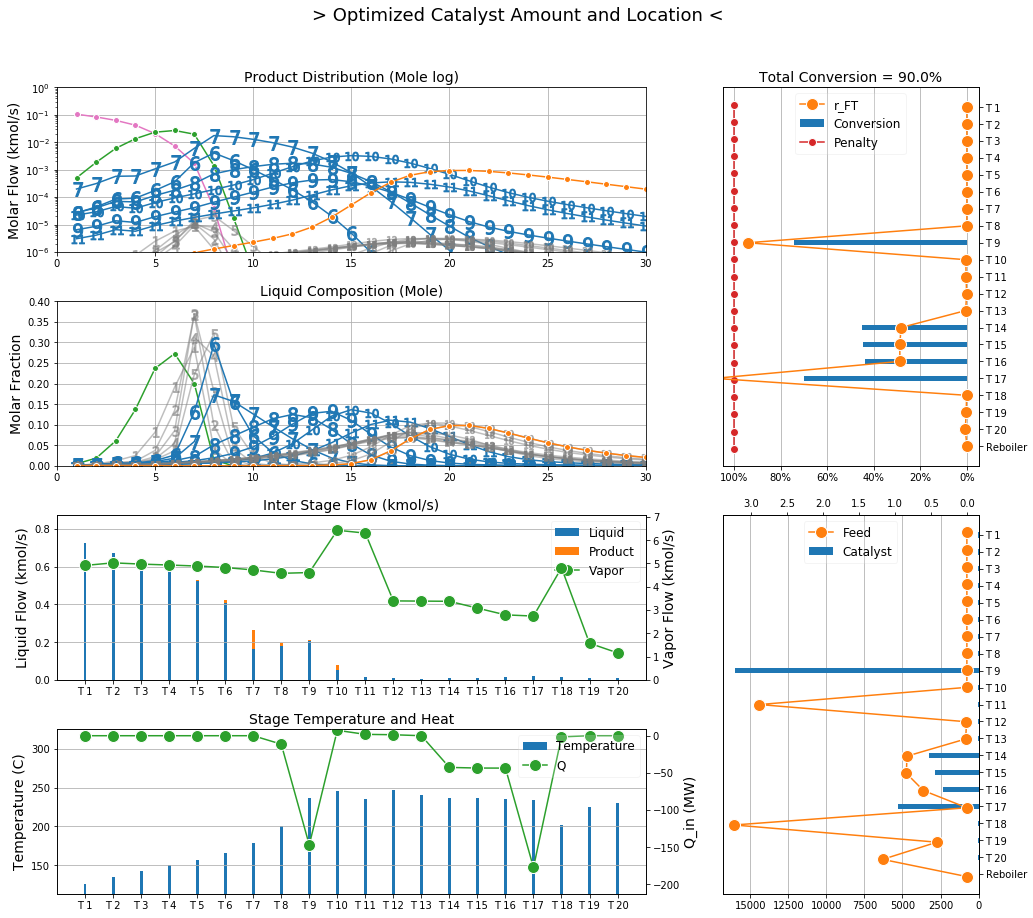

In [35]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Catalyst Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')

# Use DDF,  open up gasoline location

In [36]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [37]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2327483e-01 3.66e+01 7.18e+05  -6.0 1.13e+03    -  1.21e-02 3.02e-03h  1
  66 -1.2327067e-01 3.66e+01 2.07e+06  -6.0 1.54e+03    -  1.46e-02 9.96e-05h  1
  67 -1.2325498e-01 3.65e+01 3.44e+06  -6.0 3.14e+03    -  8.44e-03 6.93e-04h  1
  68 -1.2317266e-01 3.64e+01 4.36e+06  -6.0 3.48e+03    -  8.07e-03 3.19e-03h  1
  69r-1.2317266e-01 3.64e+01 1.00e+03   1.2 0.00e+00    -  0.00e+00 5.95e-08R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r-1.2314209e-01 3.64e+01 6.78e+04   1.2 9.07e+04    -  3.05e-07 4.35e-08f  1
  71r-1.2314209e-01 3.64e+01 9.99e+02   1.2 0.00e+00    -  0.00e+00 3.12e-07R  4
  72r-1.2314057e-01 3.64e+01 6.96e+04   1.2 8.26e+04    -  1.31e-07 2.26e-09f  1
  73 -1.2314035e-01 3.64e+01 7.36e+04  -6.0 7.90e+02    -  1.74e-03 5.08e-05h  1
  74 -1.2313969e-01 3.64e+01 4.65e+04  -6.0 1.11e+03    -  5.22e-05 3.35e-05h  1
  75 -1.2313325e-01 3.64e+01 5.28e+04  -6.0 1.12e+03    -  9.15e-03 3.20e-04h  1
  76 -1.2310769e-01 3.63e+01

 158 -1.0849188e-01 3.20e+01 7.22e+04  -6.0 1.77e+03    -  2.45e-05 1.37e-04h  1
 159 -1.0849393e-01 3.20e+01 7.31e+04  -6.0 2.53e+03    -  1.34e-03 2.43e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.0849935e-01 3.20e+01 7.25e+04  -6.0 2.12e+03    -  2.11e-04 7.61e-05h  1
 161 -1.0848802e-01 3.20e+01 1.68e+06  -6.0 2.14e+03    -  2.15e-02 2.71e-04h  1
 162 -1.0848135e-01 3.20e+01 1.72e+06  -6.0 3.49e+03    -  5.39e-04 1.31e-04h  1
 163 -1.0846706e-01 3.20e+01 4.95e+06  -6.0 5.75e+03    -  1.96e-02 3.32e-04h  1
 164 -1.0841979e-01 3.20e+01 4.91e+06  -6.0 7.46e+03    -  1.03e-03 1.30e-03h  1
 165r-1.0841979e-01 3.20e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 6.20e-08R  2
 166r-1.0841979e-01 3.20e+01 1.92e+04   1.1 6.18e+04    -  8.66e-07 4.79e-12f  2
 167r-1.0841979e-01 3.20e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 4.58e-09R  2
 168r-1.0841784e-01 3.20e+01 8.03e+04   1.1 7.45e+04    -  6.83e-08 1.96e-09f  1
 169 -1.0841815e-01 3.20e+01

 251 -1.0825255e-01 3.16e+01 9.42e+04  -6.0 1.95e+03    -  2.31e-05 1.30e-04h  1
 252 -1.0825432e-01 3.16e+01 9.53e+04  -6.0 2.91e+03    -  1.78e-03 1.99e-05h  1
 253 -1.0826063e-01 3.15e+01 9.47e+04  -6.0 2.31e+03    -  1.89e-04 8.41e-05h  1
 254 -1.0825370e-01 3.15e+01 2.51e+06  -6.0 4.30e+03    -  2.73e-02 2.09e-04h  1
 255 -1.0825047e-01 3.15e+01 2.54e+06  -6.0 4.84e+03    -  4.70e-04 9.63e-05h  1
 256 -1.0824713e-01 3.15e+01 8.16e+06  -6.0 7.64e+03    -  3.69e-02 1.00e-03h  1
 257r-1.0824713e-01 3.15e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 4.40e-08R  2
 258r-1.0823533e-01 3.15e+01 8.57e+04   1.1 6.30e+04    -  3.69e-07 2.78e-08f  1
 259r-1.0823533e-01 3.15e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 4.02e-07R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r-1.0823411e-01 3.15e+01 6.80e+04   1.1 6.19e+04    -  7.36e-08 1.47e-09f  1
 261 -1.0823435e-01 3.15e+01 1.88e+04  -6.0 5.48e+02    -  4.02e-04 2.15e-05h  1
 262 -1.0824212e-01 3.15e+01

 344 -1.0704412e-01 2.98e+01 3.73e+06  -6.0 6.75e+03    -  1.17e-02 7.59e-03h  1
 345 -1.0698017e-01 2.97e+01 4.79e+06  -6.0 8.44e+03    -  5.93e-03 1.55e-03h  1
 346r-1.0698017e-01 2.97e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 2.83e-08R  2
 347r-1.0697123e-01 2.97e+01 8.00e+04   1.1 2.67e+05    -  1.86e-07 2.53e-08f  1
 348r-1.0697123e-01 2.97e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 2.11e-07R  2
 349r-1.0697017e-01 2.97e+01 6.40e+04   1.1 5.32e+04    -  2.60e-07 1.56e-09f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -1.0697038e-01 2.97e+01 3.55e+04  -6.0 1.54e+03    -  7.39e-04 2.34e-05h  1
 351r-1.0697038e-01 2.97e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 1.58e-08R  2
 352r-1.0696931e-01 2.97e+01 7.50e+04   1.1 2.06e+08    -  2.14e-07 2.29e-09f  1
 353r-1.0696931e-01 2.97e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 2.51e-07R  3
 354r-1.0696861e-01 2.97e+01 6.40e+04   1.1 4.35e+04    -  1.69e-07 1.56e-09f  1
 355 -1.0696878e-01 2.97e+01

 437 -1.0701809e-01 2.96e+01 1.65e+05  -6.0 6.15e+03    -  1.05e-02 4.46e-05h  1
 438 -1.0702078e-01 2.96e+01 1.73e+05  -6.0 6.29e+03    -  9.27e-05 1.26e-04h  1
 439r-1.0702078e-01 2.96e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 1.64e-08R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r-1.0702077e-01 2.96e+01 4.80e+04   1.1 4.81e+04    -  3.34e-07 3.47e-11f  1
 441r-1.0702077e-01 2.96e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 9.35e-08R  2
 442r-1.0702007e-01 2.96e+01 6.36e+04   1.1 4.02e+04    -  3.22e-07 1.56e-09f  1
 443 -1.0702024e-01 2.96e+01 1.13e+05  -6.0 1.37e+02    -  2.29e-03 1.90e-05h  1
 444 -1.0702081e-01 2.96e+01 1.43e+05  -6.0 6.00e+03    -  2.10e-05 2.66e-05h  1
 445 -1.0702173e-01 2.96e+01 1.65e+05  -6.0 6.15e+03    -  1.07e-02 4.43e-05h  1
 446 -1.0702443e-01 2.96e+01 1.74e+05  -6.0 6.28e+03    -  9.22e-05 1.27e-04h  1
 447r-1.0702443e-01 2.96e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 1.66e-08R  2
 448r-1.0702441e-01 2.96e+01


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 86.59%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -141.                                        2.1895          0.6199  0.0746       2.2493

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
React[1]     123.9  0.000       0.000  0.001  0.000  732.8       5.1337  0.0000  0.7446  0.0000       20.000
React[2]     134.0  0.000       0.000  0.002  0.000  805.7       5.2598  0.0000  0.6894  0.0000       20.000
React[3]     141.8  0.000       0.000  0.002  0.000  837.0       5.2061  0.0000  0.6411  0.0000       20.000
React[4]     149.0  0.000       0.001  0.002  0.

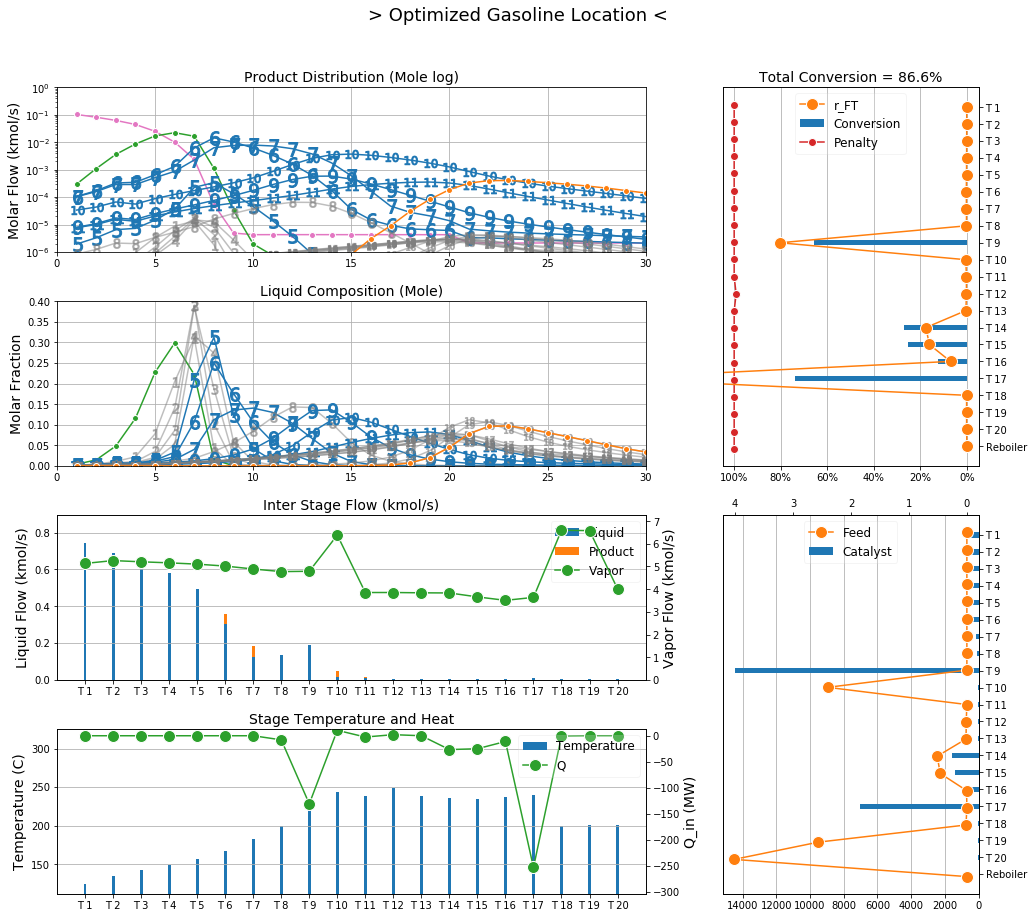

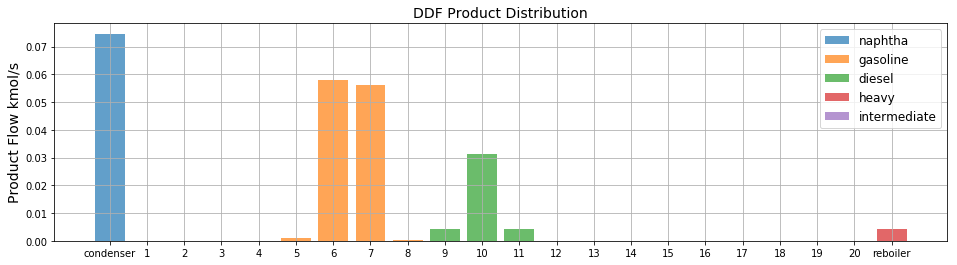

In [38]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [39]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(5)
model.N_tray['diesel'].setub(20)

In [40]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  66r-1.0490328e-01 2.77e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 5.61e-08R  2
  67r-1.0490275e-01 2.77e+01 5.65e+04   1.1 4.33e+04    -  6.12e-07 1.75e-09f  1
  68 -1.0490291e-01 2.77e+01 8.90e+03  -6.0 1.32e+02    -  1.98e-04 1.76e-05h  1
  69 -1.0490326e-01 2.77e+01 5.48e+03  -6.0 5.86e+03    -  1.98e-05 1.29e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0490287e-01 2.77e+01 1.90e+04  -6.0 5.67e+03    -  2.07e-03 1.80e-05h  1
  71 -1.0490028e-01 2.77e+01 2.48e+04  -6.0 5.80e+03    -  5.14e-05 1.57e-04h  1
  72r-1.0490028e-01 2.77e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 3.35e-07R  2
  73r-1.0490028e-01 2.77e+01 8.31e+03   1.1 4.34e+04    -  6.22e-07 1.13e-11f  1
  74r-1.0490028e-01 2.77e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 4.17e-08R  2
  75r-1.0489975e-01 2.77e+01 5.64e+04   1.1 4.32e+04    -  6.16e-07 1.75e-09f  1
  76 -1.0489991e-01 2.77e+01 9.15e+03  -6.0 1.32e+02    -  2.03e-04 1.76e-05h  1
  77 -1.0490027e-01 2.77e+01

 159 -1.0487174e-01 2.77e+01 4.74e+04  -6.0 5.82e+03    -  5.07e-05 1.59e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r-1.0487174e-01 2.77e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 3.36e-07R  3
 161r-1.0487173e-01 2.77e+01 2.18e+04   1.1 4.27e+04    -  6.69e-07 2.36e-11f  1
 162r-1.0487173e-01 2.77e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 4.56e-08R  2
 163r-1.0487120e-01 2.77e+01 5.63e+04   1.1 4.25e+04    -  6.55e-07 1.75e-09f  1
 164 -1.0487136e-01 2.77e+01 9.43e+03  -6.0 1.39e+02    -  2.08e-04 1.75e-05h  1
 165 -1.0487177e-01 2.77e+01 5.76e+03  -6.0 5.90e+03    -  1.97e-05 1.27e-05h  1
 166 -1.0487145e-01 2.77e+01 4.05e+04  -6.0 5.73e+03    -  4.50e-03 1.81e-05h  1
 167 -1.0486948e-01 2.77e+01 4.95e+04  -6.0 5.82e+03    -  5.06e-05 1.59e-04h  1
 168r-1.0486948e-01 2.77e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 3.51e-07R  3
 169r-1.0486947e-01 2.77e+01 2.48e+04   1.1 4.27e+04    -  6.37e-07 2.48e-11f  1
iter    objective    inf_pr 

 252 -1.0484892e-01 2.76e+01 9.89e+03  -6.0 1.55e+02    -  2.17e-04 1.74e-05h  1
 253 -1.0484935e-01 2.76e+01 5.88e+03  -6.0 5.92e+03    -  1.96e-05 1.23e-05h  1
 254 -1.0484907e-01 2.76e+01 5.97e+04  -6.0 5.77e+03    -  6.73e-03 1.84e-05h  1
 255 -1.0484751e-01 2.76e+01 7.34e+04  -6.0 5.80e+03    -  5.03e-05 1.60e-04h  1
 256r-1.0484751e-01 2.76e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 2.55e-07R  4
 257r-1.0484750e-01 2.76e+01 5.04e+04   1.1 4.21e+04    -  1.77e-07 3.76e-11f  1
 258r-1.0484750e-01 2.76e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 4.89e-08R  2
 259r-1.0484698e-01 2.76e+01 5.61e+04   1.1 4.18e+04    -  6.99e-07 1.76e-09f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -1.0484713e-01 2.76e+01 9.95e+03  -6.0 1.57e+02    -  2.19e-04 1.74e-05h  1
 261 -1.0484756e-01 2.76e+01 5.90e+03  -6.0 5.92e+03    -  1.96e-05 1.23e-05h  1
 262 -1.0484728e-01 2.76e+01 6.14e+04  -6.0 5.77e+03    -  6.93e-03 1.84e-05h  1
 263 -1.0484576e-01 2.76e+01

 346r-1.0483041e-01 2.75e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 5.14e-08R  2
 347r-1.0482989e-01 2.75e+01 5.59e+04   1.1 4.14e+04    -  7.39e-07 1.76e-09f  1
 348 -1.0483004e-01 2.75e+01 1.10e+04  -6.0 1.92e+02    -  2.41e-04 1.74e-05h  1
 349 -1.0483047e-01 2.75e+01 6.43e+03  -6.0 5.91e+03    -  1.95e-05 1.19e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -1.0483021e-01 2.75e+01 7.16e+04  -6.0 5.78e+03    -  8.19e-03 1.91e-05h  1
 351 -1.0482913e-01 2.75e+01 8.90e+04  -6.0 5.69e+03    -  5.05e-05 1.60e-04h  1
 352r-1.0482913e-01 2.75e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 2.80e-07R  4
 353r-1.0482912e-01 2.75e+01 5.60e+04   1.1 4.14e+04    -  2.24e-08 4.64e-11f  1
 354r-1.0482912e-01 2.75e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 5.16e-08R  2
 355r-1.0482860e-01 2.75e+01 5.59e+04   1.1 4.14e+04    -  7.42e-07 1.76e-09f  1
 356 -1.0482875e-01 2.75e+01 1.12e+04  -6.0 1.97e+02    -  2.44e-04 1.74e-05h  1
 357 -1.0482918e-01 2.75e+01

 439 -1.0482003e-01 2.75e+01 8.79e+04  -6.0 5.17e+03    -  5.29e-05 1.48e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r-1.0482003e-01 2.75e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 4.00e-07R  3
 441r-1.0482001e-01 2.75e+01 5.60e+04   1.1 4.09e+04    -  1.93e-08 5.01e-11f  1
 442r-1.0482001e-01 2.75e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 5.24e-08R  2
 443r-1.0481949e-01 2.75e+01 5.57e+04   1.1 4.10e+04    -  7.83e-07 1.77e-09f  1
 444 -1.0481964e-01 2.75e+01 1.70e+04  -6.0 3.09e+02    -  3.60e-04 1.75e-05h  1
 445 -1.0482006e-01 2.75e+01 9.83e+03  -6.0 5.85e+03    -  1.96e-05 1.17e-05h  1
 446 -1.0481978e-01 2.75e+01 7.75e+04  -6.0 5.73e+03    -  8.84e-03 2.22e-05h  1
 447 -1.0481995e-01 2.75e+01 8.65e+04  -6.0 5.06e+03    -  5.35e-05 1.45e-04h  1
 448r-1.0481995e-01 2.75e+01 1.00e+03   1.1 0.00e+00    -  0.00e+00 3.74e-07R  3
 449r-1.0481993e-01 2.75e+01 5.60e+04   1.1 4.08e+04    -  1.91e-08 5.03e-11f  1
iter    objective    inf_pr 


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 86.16%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -141.                                        2.2535          0.6354  0.0711       2.2207

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
React[1]     123.7  0.000       0.000  0.001  0.000  744.9       5.1809  0.0000  0.7653  0.0000       20.000
React[2]     133.9  0.000       0.000  0.002  0.000  819.1       5.3123  0.0000  0.7102  0.0000       20.000
React[3]     141.8  0.000       0.000  0.002  0.000  850.9       5.2589  0.0000  0.6611  0.0000       20.000
React[4]     149.0  0.000       0.001  0.002  0.00

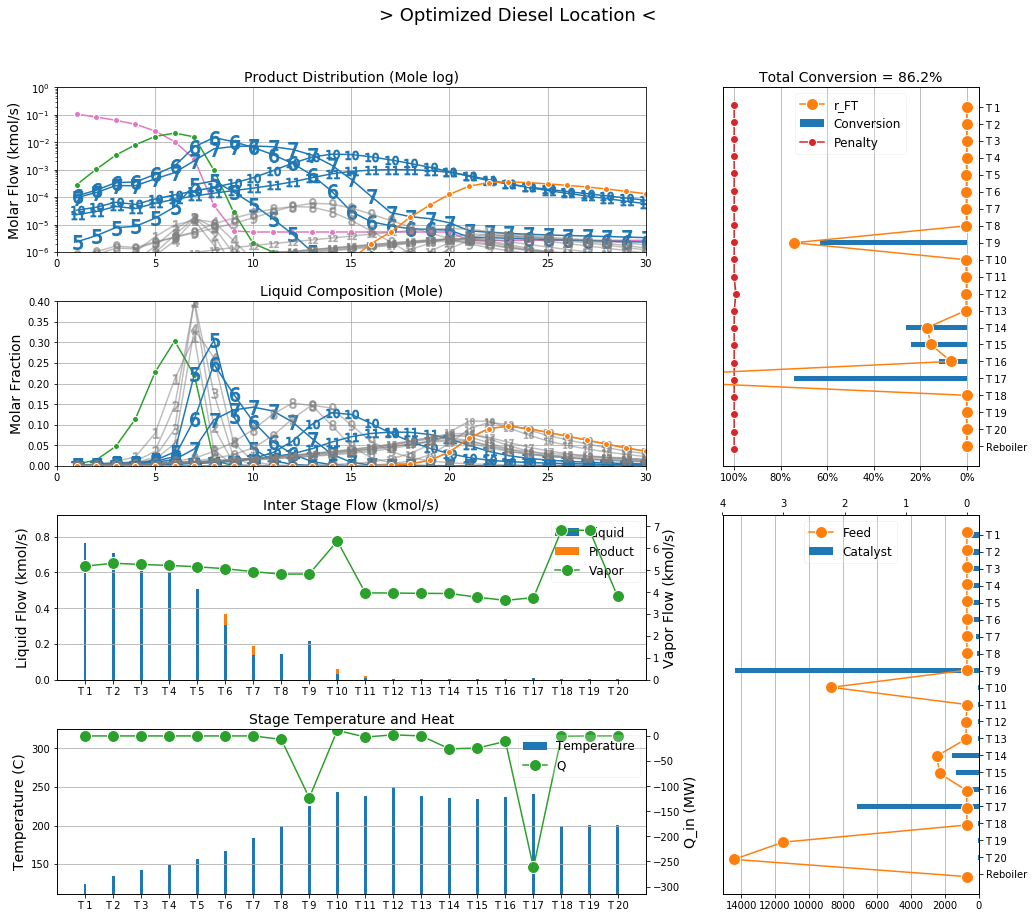

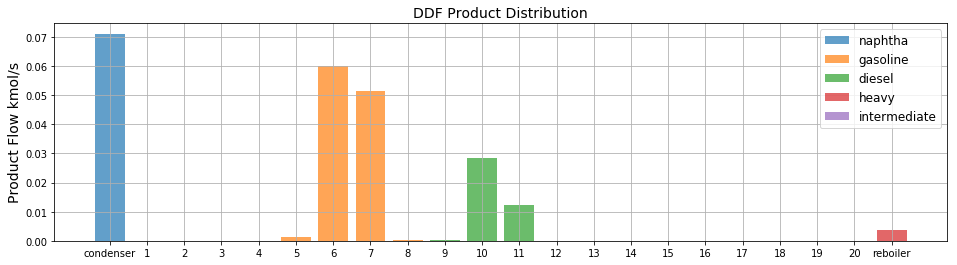

In [41]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [42]:
pdf.close()

In [43]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)